# Use deep learning to determine whether MRI images show a brain tumor

Images from https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection 

In [1]:
import os
os.environ['PYTHONHASHSEED']=str(1)
import random
random.seed(1)
import numpy as np
np.random.seed(1)
from tensorflow.random import set_seed
set_seed(1)


#libraries and load data
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns

#filepath of images
filepath = './Tumor_Images/brain_tumor_dataset'

#224 x 224 is a default target size
img_height = 224 
img_width = 224

batch_size = 40

seed = 1

#there are not so many images in the dataset, so to avoid overfitting, we'll use the ImageDataGenerator below that will
#randomly apply distortions to the images
train_datagen = ImageDataGenerator(rescale=1./255,
                             width_shift_range=0.02,
                             height_shift_range=0.02,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.2)

train_generator = train_datagen.flow_from_directory(filepath,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    subset = 'training',
                                                    seed = seed)

validation_generator = train_datagen.flow_from_directory(filepath,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        class_mode='binary',
                                                        subset = 'validation',
                                                        seed = seed)
                                                        

Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


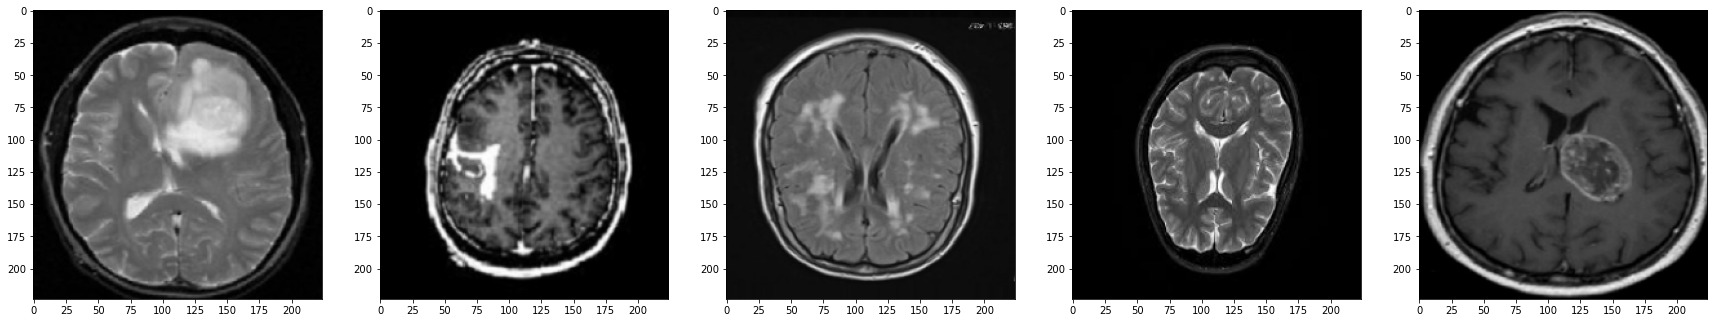

In [2]:
#print example images
X, y = train_generator.next()

def print_batch(images):
    fig = plt.figure(figsize=(30,10))
    if batch_size > 5:
        for i in range(5):
            fig.add_subplot(151+i)
            plt.imshow(images[i],cmap=plt.get_cmap('gray'));
    else:
        for i in range(batch_size):
            fig.add_subplot(151+i)
            plt.imshow(images[i],cmap=plt.get_cmap('gray'));
        
print_batch(X)

## Modeling and analysis

In [ ]:
#generate model
model = Sequential([
    Conv2D(filters = 32 , kernel_size = (3,3), activation="relu", input_shape=(img_height,img_width,3)),
    Conv2D(filters = 64 , kernel_size = (3,3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(), #reshapes image
    Dense(32, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

#compile model.
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])

#fit model
model.fit(train_generator, batch_size=batch_size, epochs=3, validation_data = validation_generator,verbose=2);

Epoch 1/3
6/6 - 16s - loss: 0.8462 - accuracy: 0.5074 - val_loss: 0.5505 - val_accuracy: 0.7200 - 16s/epoch - 3s/step
Epoch 2/3


This seems to work reasonably well. Depending on the random aspect, the val_accuracy seems to land frequently in the upper 70's

## Confusion matrix

In [ ]:
labels = validation_generator.labels
labels_pred = model.predict(validation_generator)

cm = confusion_matrix(labels, labels_pred > 0.5)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('True Negative (No tumor present or detected): ', cm[0][0])
print('False Negative (Tumor present but not detected): ', cm[1][0])
print('False Positive (Tumor absent but a tumor is detected): ', cm[0][1])
print('True Negative (Tumor present and detected): ', cm[1][1])